In [1]:
# cell #1 - 導入函式庫與設定設備
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.nn.functional as F # Added for GELU or other activations if needed

# 設定設備 (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
# cell #2 - 設定資料路徑與基本參數
# --- 設定資料路徑 ---
BASE_DIR = "Dataset/" # 請依照你的資料夾路徑修改
TRAIN_IMAGE_DIR = os.path.join(BASE_DIR, "Train/Image/")
TRAIN_MASK_DIR = os.path.join(BASE_DIR, "Train/Mask/")
TEST_IMAGE_DIR = os.path.join(BASE_DIR, "Test/Image/") # 測試集影像資料夾

# --- 基本參數 ---
IMAGE_HEIGHT = 128  # 影像高度 (可調整)
IMAGE_WIDTH = 128   # 影像寬度 (可調整)
BATCH_SIZE = 16     # 批次大小 (可調整)
EPOCHS = 25         # 訓練週期 (可調整)
LEARNING_RATE = 1e-4 # 學習率 (可調整)
VAL_SPLIT = 0.2     # 驗證集比例

# --- TransUNet Specific Parameters (can be tuned) ---
TRANSFORMER_PATCH_SIZE = 1 # Patch size for the feature map input to Transformer. 1 means each pixel in the feature map is a patch.
TRANSFORMER_EMBED_DIM = 512 # Embedding dimension for Transformer (should match channel dim of bottleneck feature map if patch_size=1)
TRANSFORMER_DEPTH = 4 # Number of Transformer encoder layers
TRANSFORMER_NUM_HEADS = 8 # Number of attention heads
TRANSFORMER_MLP_RATIO = 4.0 # Ratio for MLP hidden dimension
TRANSFORMER_DROPOUT_RATE = 0.1

In [4]:
# cell #3 - 定義 SegmentationDataset 類別
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, image_ids, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_ids = image_ids
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx] # 例如 "00001.jpg"
        
        img_path = os.path.join(self.image_dir, img_id)
        image_pil = Image.open(img_path).convert("L") 

        if self.transform:
            image_tensor = self.transform(image_pil)
        else:
            image_tensor = transforms.ToTensor()(image_pil)

        if self.mask_dir: 
            mask_filename = img_id.replace('.jpg', '.png')
            mask_path = os.path.join(self.mask_dir, mask_filename)
            mask_pil = Image.open(mask_path).convert("L")

            if self.mask_transform:
                mask_tensor = self.mask_transform(mask_pil) 
                mask_tensor = (mask_tensor > 0.5).float() 
            else:
                mask_tensor = transforms.ToTensor()(mask_pil)
                mask_tensor = (mask_tensor > 0.5).float()
        else: 
            mask_tensor = torch.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH), dtype=torch.float32)

        return image_tensor, mask_tensor

In [5]:
# cell #4 - 定義影像與遮罩的轉換
image_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.5], std=[0.5]) # 可選
])

mask_transform = transforms.Compose([
    transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

In [6]:
# cell #5 - 準備訓練集與驗證集的 DataLoader
all_train_image_files = [f for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.jpg')]
# train_ids = [os.path.splitext(f)[0] for f in all_train_image_files] # Not used directly

train_img_ids, val_img_ids = train_test_split(all_train_image_files, test_size=VAL_SPLIT, random_state=42)

print(f"Total training images: {len(all_train_image_files)}")
print(f"Number of training images: {len(train_img_ids)}")
print(f"Number of validation images: {len(val_img_ids)}")

train_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    image_ids=train_img_ids,
    transform=image_transform,
    mask_transform=mask_transform
)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()//2 if os.cpu_count() > 1 else 0)

val_dataset = SegmentationDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    image_ids=val_img_ids,
    transform=image_transform,
    mask_transform=mask_transform
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2 if os.cpu_count() > 1 else 0)

images, masks = next(iter(train_loader))
print(f"Sample batch - Images shape: {images.shape}, Masks shape: {masks.shape}")
print(f"Sample batch - Images dtype: {images.dtype}, Masks dtype: {masks.dtype}")
print(f"Sample batch - Images min/max: {images.min()}/{images.max()}")
print(f"Sample batch - Masks min/max: {masks.min()}/{masks.max()}")

Total training images: 1087
Number of training images: 869
Number of validation images: 218
Sample batch - Images shape: torch.Size([16, 1, 128, 128]), Masks shape: torch.Size([16, 1, 128, 128])
Sample batch - Images dtype: torch.float32, Masks dtype: torch.float32
Sample batch - Images min/max: 0.007843137718737125/1.0
Sample batch - Masks min/max: 0.0/1.0


In [7]:
# cell #6 - 定義 TransUNet 模型架構

# --- U-Net Components (from your code) ---
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = nn.functional.pad(x1, [diffX // 2, diffX - diffX // 2,
                                    diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# --- Transformer Components ---
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, drop=0., attn_drop=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias, attn_drop=attn_drop, proj_drop=drop)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class PatchEmbed(nn.Module):
    """ Image to Patch Embedding
    Args:
        patch_size (int): Patch token size. Default: 1 (if feature map is already small).
        in_chans (int): Number of input image channels. Default: 512 (bottleneck channel).
        embed_dim (int): Number of linear projection output channels. Default: 512.
    """
    def __init__(self, patch_size=1, in_chans=512, embed_dim=512):
        super().__init__()
        self.patch_size = patch_size
        # Using a Conv2d for patch embedding allows flexibility, 
        # but if patch_size=1, it's essentially a 1x1 conv to adjust channels if needed.
        # If in_chans == embed_dim and patch_size == 1, this layer is just a reshape.
        # For simplicity, we assume in_chans will be embed_dim for patch_size=1.
        if patch_size > 1: # if patch_size is larger than 1, use a conv to create patches
             self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        elif in_chans != embed_dim: # if patch_size is 1 but channels differ, use 1x1 conv
            self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=1, stride=1)
        else: # patch_size is 1 and channels match, no conv needed for projection
            self.proj = nn.Identity()


    def forward(self, x):
        # x is (B, C, H, W) from CNN encoder
        B, C, H, W = x.shape
        x = self.proj(x) # (B, embed_dim, H/patch_size, W/patch_size)
        # Flatten: (B, embed_dim, num_patches_h * num_patches_w)
        # Transpose to: (B, num_patches, embed_dim)
        x = x.flatten(2).transpose(1, 2)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, embed_dim, depth, num_heads, mlp_ratio=4.0, dropout_rate=0.1):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerBlock(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                drop=dropout_rate,
                attn_drop=dropout_rate
            )
            for _ in range(depth)])
        self.norm = nn.LayerNorm(embed_dim) # Final normalization

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        x = self.norm(x)
        return x

# --- TransUNet Model ---
class TransUNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True,
                 img_dim=128, cnn_feature_dim=512, # cnn_feature_dim is channels from down4
                 patch_size=TRANSFORMER_PATCH_SIZE, 
                 embed_dim=TRANSFORMER_EMBED_DIM, 
                 depth=TRANSFORMER_DEPTH, 
                 num_heads=TRANSFORMER_NUM_HEADS,
                 mlp_ratio=TRANSFORMER_MLP_RATIO, 
                 dropout_rate=TRANSFORMER_DROPOUT_RATE):
        super(TransUNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        # CNN Encoder
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, cnn_feature_dim // factor) # Output channels: 512 if factor=2 (bilinear)
                                                       # Output channels: 1024 if factor=1
        
        # Calculate feature map size after CNN encoder
        # Example: img_dim=128, 4 downsamplings -> 128 / (2^4) = 128 / 16 = 8
        self.feature_map_size = img_dim // (2**4) 
        
        # Ensure embed_dim matches output of down4 if patch_size=1
        # Or adjust cnn_feature_dim in Down(512, cnn_feature_dim // factor)
        # For this setup, cnn_feature_dim // factor should be embed_dim
        current_cnn_bottleneck_channels = cnn_feature_dim // factor
        if current_cnn_bottleneck_channels != embed_dim and patch_size == 1:
            print(f"Warning: CNN bottleneck channels ({current_cnn_bottleneck_channels}) != Transformer embed_dim ({embed_dim}) with patch_size=1.")
            print("PatchEmbed will use a 1x1 conv to match dimensions, or ensure they are equal.")


        # Transformer Encoder
        self.patch_embed = PatchEmbed(patch_size=patch_size, 
                                      in_chans=current_cnn_bottleneck_channels, 
                                      embed_dim=embed_dim)
        num_patches = (self.feature_map_size // patch_size) * (self.feature_map_size // patch_size)
        self.positional_embedding = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
        self.dropout = nn.Dropout(dropout_rate)
        
        self.transformer_encoder = TransformerEncoder(embed_dim=embed_dim, 
                                                      depth=depth, 
                                                      num_heads=num_heads, 
                                                      mlp_ratio=mlp_ratio,
                                                      dropout_rate=dropout_rate)

        # CNN Decoder
        # Input to up1 is embed_dim (from transformer) + 512 (from x4 skip connection)
        # Original up1 took 1024 (from x5_upsampled + x4)
        # The output of transformer will have embed_dim channels.
        # x4 has 512 channels.
        # So, input to DoubleConv in up1 will be embed_dim + 512
        self.up1 = Up(embed_dim + 512, 512 // factor, bilinear) # Input channels adjusted
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        # CNN Encoder
        x1 = self.inc(x)    # (B, 64, H, W)
        x2 = self.down1(x1) # (B, 128, H/2, W/2)
        x3 = self.down2(x2) # (B, 256, H/4, W/4)
        x4 = self.down3(x3) # (B, 512, H/8, W/8)
        x5 = self.down4(x4) # (B, cnn_bottleneck_channels, H/16, W/16)
                            # e.g., (B, 512, 8, 8) for IMAGE_HEIGHT=128, bilinear=True

        # Transformer
        B, C_bot, H_bot, W_bot = x5.shape # (B, 512, 8, 8)
        
        transformer_input = self.patch_embed(x5) # (B, num_patches, embed_dim)
                                                 # e.g., (B, 64, 512) if patch_size=1
        
        transformer_input = transformer_input + self.positional_embedding
        transformer_input = self.dropout(transformer_input)
        
        transformer_output = self.transformer_encoder(transformer_input) # (B, num_patches, embed_dim)
        
        # Reshape Transformer output back to 2D feature map
        # (B, num_patches, embed_dim) -> (B, embed_dim, H_bot/patch_size, W_bot/patch_size)
        # If patch_size=1, then (B, embed_dim, H_bot, W_bot)
        # H_bot_tr = H_bot // self.patch_embed.patch_size
        # W_bot_tr = W_bot // self.patch_embed.patch_size
        # The patch_embed output spatial dim is H_bot, W_bot if patch_size=1
        # and its channel dim is embed_dim.
        # The H_bot, W_bot here are after patch_embed's projection conv.
        # If patch_size = 1 for PatchEmbed, then H_after_proj = H_bot, W_after_proj = W_bot
        # If patch_size > 1 for PatchEmbed, then H_after_proj = H_bot / patch_size, etc.
        
        # We need to know the spatial dimensions after PatchEmbed's projection for reshaping.
        # If self.patch_embed.proj is nn.Identity, H_out_proj = H_bot.
        # If self.patch_embed.proj is a Conv2d, its output spatial dim needs to be calculated.
        # For patch_size = 1, H_out_proj = H_bot.
        # For patch_size = P > 1, H_out_proj = H_bot / P.
        
        h_feat_map_tr = self.feature_map_size // self.patch_embed.patch_size
        w_feat_map_tr = self.feature_map_size // self.patch_embed.patch_size

        transformer_output = transformer_output.transpose(1, 2).reshape(B, TRANSFORMER_EMBED_DIM, h_feat_map_tr, w_feat_map_tr)
        # Now transformer_output is (B, embed_dim, H_bot/patch_size, W_bot/patch_size)
        # e.g., (B, 512, 8, 8) if patch_size=1

        # CNN Decoder
        # x5 is the feature from CNN encoder that would have gone to up1 in original U-Net.
        # Now, transformer_output takes its place.
        # x4 is (B, 512, H/8, W/8) e.g., (B, 512, 16, 16)
        # transformer_output is (B, embed_dim, H/16, W/16) e.g. (B, 512, 8, 8)

        x = self.up1(transformer_output, x4) # up1 expects first arg (x1) to be smaller spatially
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

# Initialize TransUNet model
# Ensure cnn_feature_dim // factor in TransUNet init matches TRANSFORMER_EMBED_DIM for simplicity
# or that PatchEmbed handles the channel conversion.
# Default U-Net has down4 outputting 1024//factor channels. If bilinear=True, factor=2, so 512 channels.
# This matches our default TRANSFORMER_EMBED_DIM = 512.
model = TransUNet(
    n_channels=1, 
    n_classes=1, 
    bilinear=True,
    img_dim=IMAGE_HEIGHT,
    cnn_feature_dim=1024, # This is the `out_channels` for the `Down` conv block before Transformer.
                          # So, `down4` will aim for `1024 // factor` channels.
                          # If bilinear=True (factor=2), this is 512.
    patch_size=TRANSFORMER_PATCH_SIZE,
    embed_dim=TRANSFORMER_EMBED_DIM, # Should match `cnn_feature_dim // factor`
    depth=TRANSFORMER_DEPTH,
    num_heads=TRANSFORMER_NUM_HEADS,
    mlp_ratio=TRANSFORMER_MLP_RATIO,
    dropout_rate=TRANSFORMER_DROPOUT_RATE
).to(device)


# Test model with a dummy input
dummy_input = torch.randn(2, 1, IMAGE_HEIGHT, IMAGE_WIDTH).to(device) # (batch_size, channels, height, width)
try:
    output = model(dummy_input)
    print(f"Model output shape: {output.shape}") # Should be (batch_size, n_classes, IMAGE_HEIGHT, IMAGE_WIDTH)
except Exception as e:
    print(f"Error during model test forward pass: {e}")
    import traceback
    traceback.print_exc()

Model output shape: torch.Size([2, 1, 128, 128])


In [9]:
# cell #7 - 設定損失函數與優化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.1)

In [10]:
# cell #8 - 定義 Dice Coefficient 計算函數
def dice_coefficient(preds, targets, smooth=1e-6):
    preds = torch.sigmoid(preds) 
    preds = (preds > 0.5).float() 
    
    intersection = (preds * targets).sum(dim=(2, 3)) 
    union = preds.sum(dim=(2, 3)) + targets.sum(dim=(2, 3)) 
    dice = (2. * intersection + smooth) / (union + smooth) 
    return dice.mean()

In [11]:
# cell #9 - 定義訓練與驗證的單個 epoch 函數，並開始訓練模型
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train() 
    epoch_loss = 0.0
    epoch_dice = 0.0
    
    for i, (images, masks) in enumerate(loader):
        images = images.to(device)
        masks = masks.to(device) 
        
        optimizer.zero_grad() 
        outputs = model(images) 
        
        loss = criterion(outputs, masks) 
        
        loss.backward() 
        optimizer.step() 
        
        epoch_loss += loss.item()
        dice = dice_coefficient(outputs.detach(), masks.detach()) 
        epoch_dice += dice.item()

        if (i + 1) % (len(loader)//2 if len(loader) > 1 else 1) == 0 : # Print twice per epoch
             print(f"  Batch {i+1}/{len(loader)}, Train Loss: {loss.item():.4f}, Train Dice: {dice.item():.4f}")
        
    return epoch_loss / len(loader), epoch_dice / len(loader)

def validate_one_epoch(model, loader, criterion, device):
    model.eval() 
    epoch_loss = 0.0
    epoch_dice = 0.0
    
    with torch.no_grad(): 
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            epoch_loss += loss.item()
            dice = dice_coefficient(outputs, masks) 
            epoch_dice += dice.item()
            
    return epoch_loss / len(loader), epoch_dice / len(loader)

# --- 開始訓練 ---
best_val_dice = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': []}

print("Starting Training with TransUNet...")
for epoch in range(EPOCHS):
    print(f"--- Epoch {epoch+1}/{EPOCHS} ---")
    
    train_loss, train_dice = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_dice = validate_one_epoch(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)
    
    print(f"Epoch {epoch+1} Summary: ")
    print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"  Val Loss: {val_loss:.4f},   Val Dice: {val_dice:.4f}")
    
    if scheduler:
        scheduler.step(val_loss) 

    if val_dice > best_val_dice:
        best_val_dice = val_dice
        torch.save(model.state_dict(), 'best_model_transunet_segmentation.pth') # Changed filename
        print(f"  New best TransUNet model saved with Val Dice: {best_val_dice:.4f}")

print("Training Finished!")
print(f"Best Validation Dice with TransUNet: {best_val_dice:.4f}")

Starting Training with TransUNet...
--- Epoch 1/25 ---
  Batch 27/55, Train Loss: 0.3999, Train Dice: 0.7491
  Batch 54/55, Train Loss: 0.3065, Train Dice: 0.7970
Epoch 1 Summary: 
  Train Loss: 0.3803, Train Dice: 0.7652
  Val Loss: 0.3258,   Val Dice: 0.8056
  New best TransUNet model saved with Val Dice: 0.8056
--- Epoch 2/25 ---
  Batch 27/55, Train Loss: 0.2805, Train Dice: 0.8112
  Batch 54/55, Train Loss: 0.2591, Train Dice: 0.8501
Epoch 2 Summary: 
  Train Loss: 0.2966, Train Dice: 0.8291
  Val Loss: 0.3171,   Val Dice: 0.7938
--- Epoch 3/25 ---
  Batch 27/55, Train Loss: 0.2961, Train Dice: 0.8008
  Batch 54/55, Train Loss: 0.2494, Train Dice: 0.8487
Epoch 3 Summary: 
  Train Loss: 0.2694, Train Dice: 0.8420
  Val Loss: 0.2712,   Val Dice: 0.8487
  New best TransUNet model saved with Val Dice: 0.8487
--- Epoch 4/25 ---
  Batch 27/55, Train Loss: 0.2467, Train Dice: 0.8116
  Batch 54/55, Train Loss: 0.2613, Train Dice: 0.8816
Epoch 4 Summary: 
  Train Loss: 0.2465, Train Dice: 

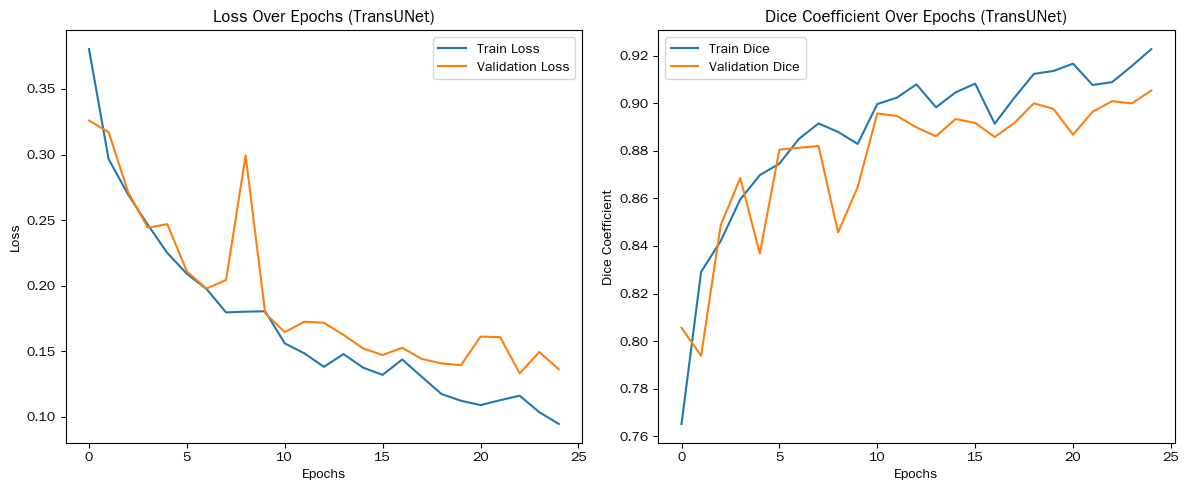

In [15]:
# cell #10 - 繪製訓練過程中的 Loss 與 Dice Coefficient 變化圖
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs (TransUNet)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice')
plt.plot(history['val_dice'], label='Validation Dice')
plt.title('Dice Coefficient Over Epochs (TransUNet)')
plt.xlabel('Epochs')
plt.ylabel('Dice Coefficient')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# cell #11 - 定義 mask_to_rle 函數
def mask_to_rle(mask):
    pixels = mask.flatten() 
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return " ".join(map(str, runs))

In [17]:
# cell #12 - 載入最佳模型，對測試集進行預測並產生提交檔案
# Load the best TransUNet model
model.load_state_dict(torch.load('best_model_transunet_segmentation.pth', map_location=device))
model.eval() 

test_image_files = [f for f in os.listdir(TEST_IMAGE_DIR) if f.endswith('.jpg')]
test_image_files.sort() 
test_ids = [os.path.splitext(f)[0] for f in test_image_files]

test_dataset = SegmentationDataset(
    image_dir=TEST_IMAGE_DIR,
    mask_dir=None, 
    image_ids=test_image_files, 
    transform=image_transform, 
    mask_transform=None
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()//2 if os.cpu_count() > 1 else 0)


submission_ids = []
submission_rles = []

print("Generating predictions for test set with TransUNet...")
with torch.no_grad():
    current_idx = 0
    for images, _ in test_loader: 
        images = images.to(device)
        outputs = model(images) 

        probs = torch.sigmoid(outputs) 
        pred_masks = (probs > 0.5).cpu().numpy().astype(np.uint8) 

        for i in range(pred_masks.shape[0]):
            single_mask = pred_masks[i, 0, :, :] 
            # Resize mask to original image size before RLE
            # This step assumes test images might have various original sizes.
            # If all test images are guaranteed to be the same size as model input after transform,
            # then resizing here might be redundant if no resizing to original happened.
            # However, competition often requires prediction on original dimensions.
            original_img_path = os.path.join(TEST_IMAGE_DIR, test_image_files[current_idx])
            original_pil_img = Image.open(original_img_path)
            original_width, original_height = original_pil_img.size
            
            # The predicted mask is (IMAGE_HEIGHT, IMAGE_WIDTH)
            # We need to resize it to (original_height, original_width)
            single_mask_resized = cv2.resize(single_mask, (original_width, original_height), interpolation=cv2.INTER_NEAREST)
            
            rle = mask_to_rle(single_mask_resized)

            submission_ids.append(test_ids[current_idx]) 
            submission_rles.append(rle)
            current_idx += 1

submission_df = pd.DataFrame({'ID': submission_ids, 'Mask': submission_rles})
submission_df.to_csv('submission_transunet.csv', index=False) # Changed filename

print("Submission file 'submission_transunet.csv' created successfully.")
print(submission_df.head())

Generating predictions for test set with TransUNet...
Submission file 'submission_transunet.csv' created successfully.
        ID                                               Mask
0  0001087  86449 48 87473 48 88497 48 89521 48 90545 48 9...
1  0001088  154017 48 155041 48 156065 48 157089 48 158113...
2  0001089  80449 40 81473 40 82497 40 83521 40 84545 40 8...
3  0001090  270745 40 271769 40 272793 40 273817 40 274841...
4  0001091  166481 32 167505 32 168529 32 169553 32 170577...


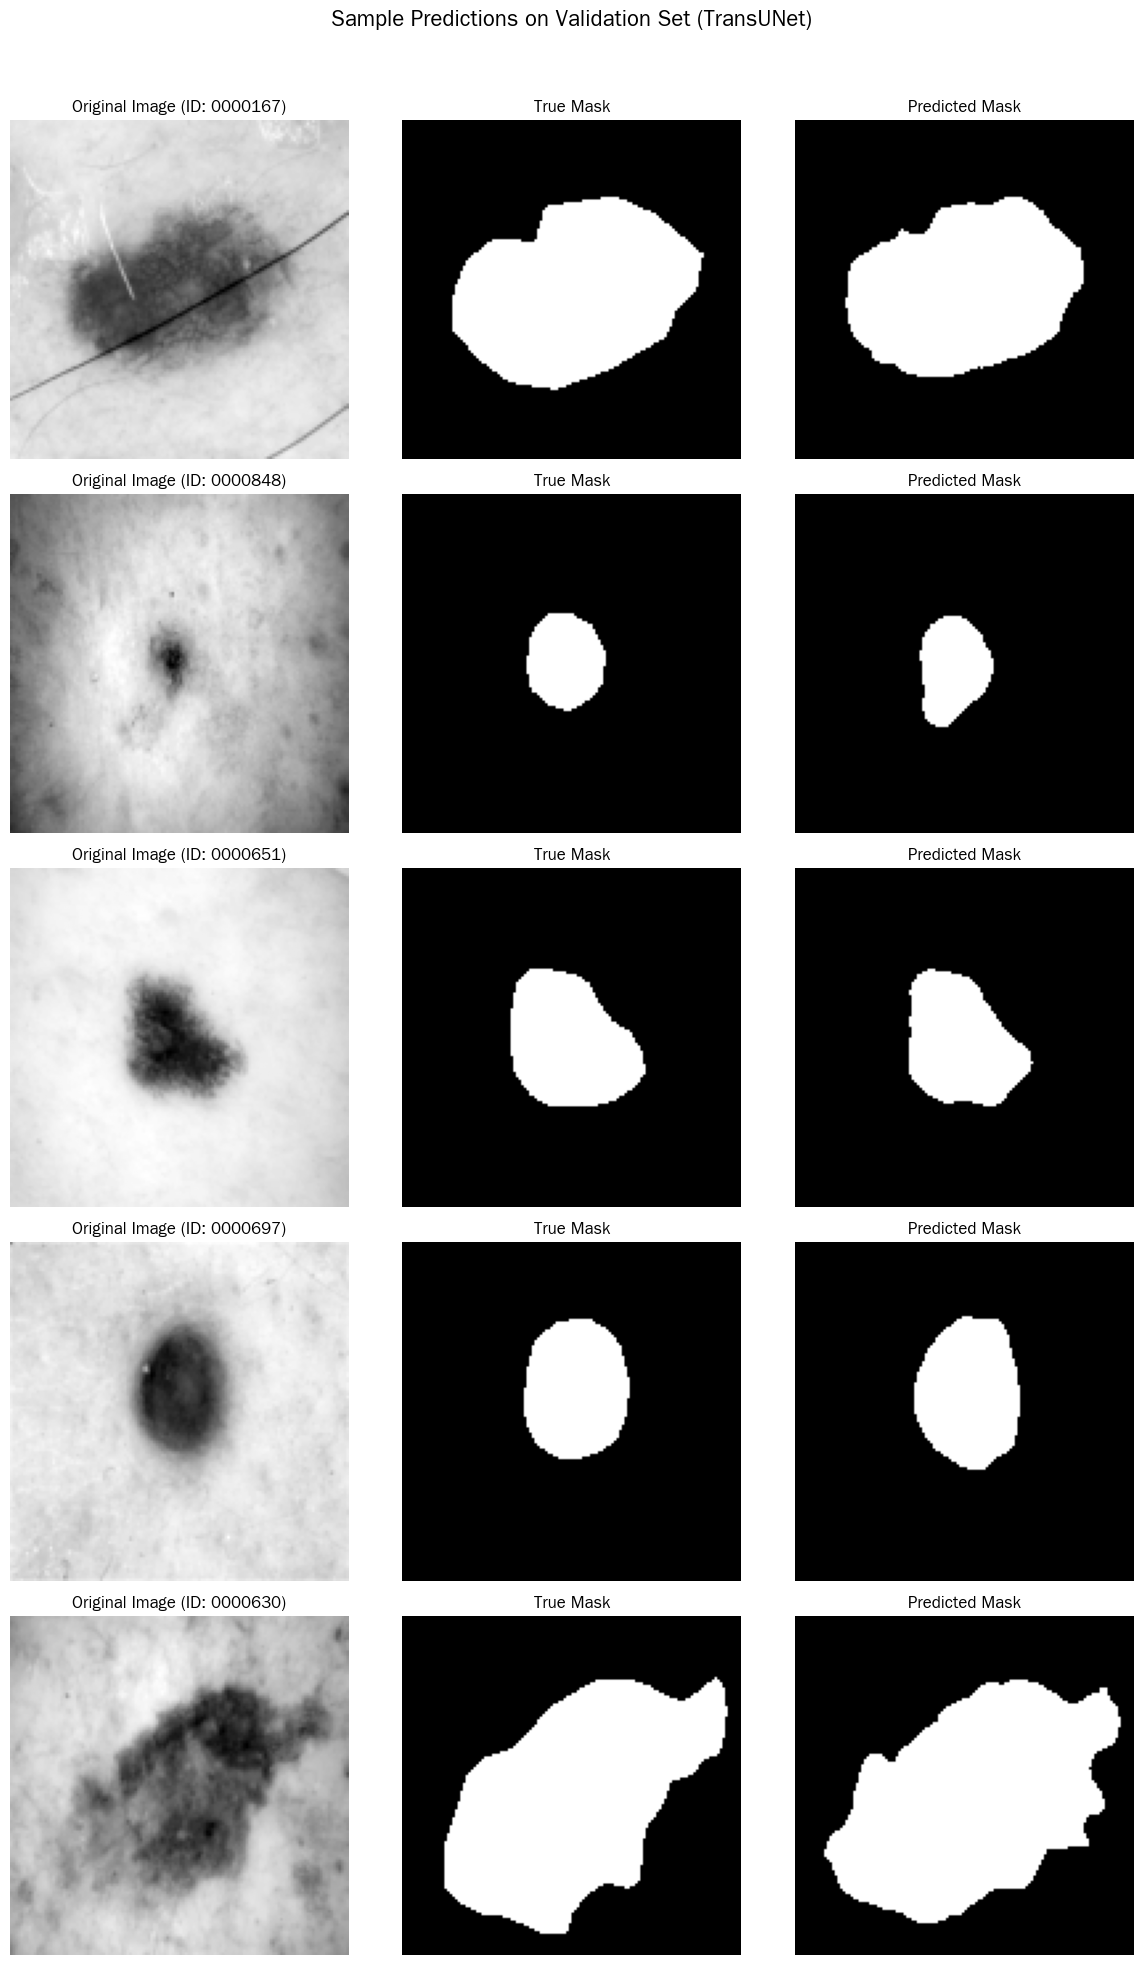

In [18]:
# cell #13 - 視覺化驗證集上的預測結果
# model.load_state_dict(torch.load('best_model_transunet_segmentation.pth', map_location=device))
# model.eval()

num_samples_to_show = 5
if len(val_dataset) == 0:
    print("Validation dataset is empty, skipping visualization.")
elif len(val_dataset) < num_samples_to_show:
    num_samples_to_show = len(val_dataset)
    print(f"Warning: Not enough samples in validation set for visualization. Showing {num_samples_to_show} samples.")


if num_samples_to_show > 0:
    indices = np.random.choice(len(val_dataset), num_samples_to_show, replace=False)

    fig, axes = plt.subplots(num_samples_to_show, 3, figsize=(12, num_samples_to_show * 4))
    if num_samples_to_show == 1: # Adjust axes indexing if only one sample
        axes = np.array([axes]) 
    fig.suptitle("Sample Predictions on Validation Set (TransUNet)", fontsize=16)

    for i, idx in enumerate(indices):
        image, true_mask = val_dataset[idx] 
        
        image_for_plot = image.squeeze().cpu().numpy() 
        true_mask_for_plot = true_mask.squeeze().cpu().numpy() 
        
        with torch.no_grad():
            input_tensor = image.unsqueeze(0).to(device) 
            output_tensor = model(input_tensor) 
            pred_prob = torch.sigmoid(output_tensor) 
            pred_mask = (pred_prob > 0.5).squeeze().cpu().numpy().astype(np.uint8) 
            
        ax_img, ax_true, ax_pred = axes[i, 0], axes[i, 1], axes[i, 2]
        
        ax_img.imshow(image_for_plot, cmap='gray')
        ax_img.set_title(f"Original Image (ID: {val_dataset.image_ids[idx].split('.')[0]})")
        ax_img.axis('off')
        
        ax_true.imshow(true_mask_for_plot, cmap='gray')
        ax_true.set_title("True Mask")
        ax_true.axis('off')
        
        ax_pred.imshow(pred_mask, cmap='gray')
        ax_pred.set_title("Predicted Mask")
        ax_pred.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) 
    plt.show()
else:
    print("No samples to visualize.")